In [1]:
import gc
gc.collect()
import numpy as np
import pandas as pd
import os
import h5py
import time
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

# TPU initialization moved to top for better efficiency
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import R2Score as RSquare
from sklearn.preprocessing import StandardScaler

# Fixed TPU strategy setup for Kaggle TPUv5
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     tpu_strategy = tf.distribute.TPUStrategy(tpu)
#     print(f"Running on TPU with {tpu_strategy.num_replicas_in_sync} cores")
# except (ValueError, RuntimeError):
tpu_strategy = tf.distribute.get_strategy()
print("Running on CPU/GPU")

all_files=[]
for dirname, _, filenames in os.walk('./data_set'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))
all_files.sort()
pprint(all_files)

2025-11-09 15:52:12.167064: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 15:52:12.178529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-09 15:52:12.193700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-09 15:52:12.197309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-09 15:52:12.207043: I tensorflow/core/platform/cpu_feature_guar

Running on CPU/GPU
['./data_set/N-CMAPSS_DS01-005.h5',
 './data_set/N-CMAPSS_DS02-006.h5',
 './data_set/N-CMAPSS_DS03-012.h5',
 './data_set/N-CMAPSS_DS04.h5',
 './data_set/N-CMAPSS_DS05.h5',
 './data_set/N-CMAPSS_DS06.h5',
 './data_set/N-CMAPSS_DS07.h5',
 './data_set/N-CMAPSS_DS08a-009.h5',
 './data_set/N-CMAPSS_DS08c-008.h5',
 './data_set/N-CMAPSS_DS08d-010.h5',
 './data_set/N-CMAPSS_Example_data_loading_and_exploration.ipynb',
 './data_set/Run_to_Failure_Simulation_Under_Real_Flight_Conditions_Dataset.pdf',
 './data_set/data-06-00005-v2.pdf',
 './data_set/flight_profile_DS02.png',
 './data_set/kde_DS02.png']


In [2]:
def read_hdf(filename):
    t = time.process_time()  
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'), dtype=np.float32)
        X_s_dev = np.array(hdf.get('X_s_dev'), dtype=np.float32)
        X_v_dev = np.array(hdf.get('X_v_dev'), dtype=np.float32)
        T_dev = np.array(hdf.get('T_dev'), dtype=np.float32)
        Y_dev = np.array(hdf.get('Y_dev'), dtype=np.float32)
        A_dev = np.array(hdf.get('A_dev'), dtype=np.float32)

        # Test set
        W_test = np.array(hdf.get('W_test'), dtype=np.float32)
        X_s_test = np.array(hdf.get('X_s_test'), dtype=np.float32)
        X_v_test = np.array(hdf.get('X_v_test'), dtype=np.float32)
        T_test = np.array(hdf.get('T_test'), dtype=np.float32)
        Y_test = np.array(hdf.get('Y_test'), dtype=np.float32)
        A_test = np.array(hdf.get('A_test'), dtype=np.float32)
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                        
    ## Train data
    df_a_dev=pd.DataFrame(A_dev,columns=A_var)
    df_t_dev=pd.DataFrame(T_dev,columns=T_var)
    df_w_dev=pd.DataFrame(W_dev,columns=W_var)
    df_xs_dev=pd.DataFrame(X_s_dev,columns=X_s_var)
    df_xv_dev=pd.DataFrame(X_v_dev,columns=X_v_var)
    df_y_dev=pd.DataFrame(Y_dev,columns=['RUL'])

    #get rul
    trainy=df_y_dev[['RUL']]

    #get x from sensors values
    trainx=pd.concat([df_xs_dev,df_w_dev],axis=1)

    print(type(trainy),trainy.shape, type(trainx), trainx.shape)

    ## Test data
    df_a_test=pd.DataFrame(A_test,columns=A_var)
    df_t_test=pd.DataFrame(T_test,columns=T_var)
    df_w_test=pd.DataFrame(W_test,columns=W_var)
    df_xs_test=pd.DataFrame(X_s_test,columns=X_s_var)
    df_xv_test=pd.DataFrame(X_v_test,columns=X_v_var)
    df_y_test=pd.DataFrame(Y_test,columns=['RUL'])

    #get health state from aux
    testy=df_y_test[['RUL']]

    #get x from sensors values
    testx=pd.concat([df_xs_test,df_w_test],axis=1)

    print(type(testy),testy.shape, type(testx), testx.shape)

    print('')
    print("Operation time (min): " , (time.process_time()-t)/60)
    print('')

    return (trainx,trainy,df_a_dev,testx,testy,df_a_test)

In [3]:
curr_file=all_files[5]
print(curr_file)

./data_set/N-CMAPSS_DS06.h5


In [4]:
trainx,trainy,adev,testx,testy,atest = read_hdf(filename=curr_file)

<class 'pandas.core.frame.DataFrame'> (4257209, 1) <class 'pandas.core.frame.DataFrame'> (4257209, 18)
<class 'pandas.core.frame.DataFrame'> (2522447, 1) <class 'pandas.core.frame.DataFrame'> (2522447, 18)

Operation time (min):  0.03338083



In [5]:
trainx.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4257209 entries, 0 to 4257208
Data columns (total 18 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   T24     4257209 non-null  float32
 1   T30     4257209 non-null  float32
 2   T48     4257209 non-null  float32
 3   T50     4257209 non-null  float32
 4   P15     4257209 non-null  float32
 5   P2      4257209 non-null  float32
 6   P21     4257209 non-null  float32
 7   P24     4257209 non-null  float32
 8   Ps30    4257209 non-null  float32
 9   P40     4257209 non-null  float32
 10  P50     4257209 non-null  float32
 11  Nf      4257209 non-null  float32
 12  Nc      4257209 non-null  float32
 13  Wf      4257209 non-null  float32
 14  alt     4257209 non-null  float32
 15  Mach    4257209 non-null  float32
 16  TRA     4257209 non-null  float32
 17  T2      4257209 non-null  float32
dtypes: float32(18)
memory usage: 292.3 MB


In [6]:
# Standard scale with memory optimization
sc=StandardScaler()
sc.fit(trainx.values)
trainx_l_sc=sc.transform(trainx.values).astype(np.float32)
testx_l_sc=sc.transform(testx.values).astype(np.float32)

print(trainx_l_sc.shape, testx_l_sc.shape, trainy.shape, testy.shape)

trainx_l_sc=pd.DataFrame(trainx_l_sc,columns=trainx.columns)
testx_l_sc=pd.DataFrame(testx_l_sc,columns=trainx.columns)

print(trainx_l_sc.shape, testx_l_sc.shape, trainy.shape, testy.shape)

(4257209, 18) (2522447, 18) (4257209, 1) (2522447, 1)
(4257209, 18) (2522447, 18) (4257209, 1) (2522447, 1)


In [7]:
def time_window_slicing_sample(input_array, window_length, unit, sequence_cols, stride=1):
    window_lst = []
    input_temp = input_array[input_array['unit'] == unit][sequence_cols].values.astype(np.float32)
    print ("Unit%s input array shape: " %unit, input_temp.shape)
    num_samples = int((input_temp.shape[0] - window_length)/stride) + 1

    for i in range(num_samples):
        window = input_temp[i*stride:i*stride + window_length,:]
        window_lst.append(window)

    sample_array = np.dstack(window_lst).astype(np.float32)
    print ("sample_array.shape", sample_array.shape)
    return sample_array

def time_window_slicing_label(input_array, window_length, unit, sequence_cols = 'RUL', stride=1):
    window_lst = []
    input_temp = input_array[input_array['unit'] == unit][sequence_cols].values.astype(np.float32)
    num_samples = int((input_temp.shape[0] - window_length)/stride) + 1
    for i in range(num_samples):
        window = input_temp[i*stride:i*stride + window_length]
        window_lst.append(window)

    label_array = np.asarray(window_lst).astype(np.float32)
    return label_array[:,-1]

In [8]:
trainy = trainy[trainy!=0].dropna()
trainx_l_sc = trainx_l_sc.loc[trainy.index]
testy = testy[testy!=0].dropna()
testx_l_sc = testx_l_sc.loc[testy.index]

print(trainx_l_sc.shape, trainy.shape, testy.shape, testx_l_sc.shape)

(4204848, 18) (4204848, 1) (2489532, 1) (2489532, 18)


In [9]:
df=trainx_l_sc.copy()
df['unit']=adev['unit']
df['RUL']=trainy['RUL']

In [10]:
# Optimized windowing with reduced window size for memory efficiency
WINDOW_SIZE = 30  # Reduced from 50
STRIDE = 15      # Reduced from 25

all_units_data=[]
for un in adev.unit.unique():
    all_units_data.append(time_window_slicing_sample(df, WINDOW_SIZE, un, df.columns.difference(['unit','RUL']), STRIDE))

all_units_data=np.dstack(all_units_data)
all_units_data=all_units_data.transpose(2,0,1)
print(all_units_data.shape)

Unit1.0 input array shape:  (707428, 18)
sample_array.shape (30, 18, 47160)
Unit2.0 input array shape:  (1139179, 18)
sample_array.shape (30, 18, 75944)
Unit3.0 input array shape:  (557353, 18)
sample_array.shape (30, 18, 37155)
Unit4.0 input array shape:  (383874, 18)
sample_array.shape (30, 18, 25590)
Unit5.0 input array shape:  (443010, 18)
sample_array.shape (30, 18, 29533)
Unit6.0 input array shape:  (974004, 18)
sample_array.shape (30, 18, 64932)
(280314, 30, 18)


In [11]:
all_labels=[]
for un in adev.unit.unique():
    all_labels=all_labels+time_window_slicing_label(df, WINDOW_SIZE, un, stride=STRIDE).tolist()

print(len(all_labels))
all_labels=np.array(all_labels, dtype=np.float32)

280314


In [12]:
#test data
df=testx_l_sc.copy()
df['unit']=atest['unit']
df['RUL']=testy['RUL']

test_units_data=[]
for un in atest.unit.unique():
    test_units_data.append(time_window_slicing_sample(df, WINDOW_SIZE, un, df.columns.difference(['unit','RUL']), STRIDE))

test_units_data=np.dstack(test_units_data)
test_units_data=test_units_data.transpose(2,0,1)
print(test_units_data.shape)

test_labels=[]
for un in atest.unit.unique():
    test_labels=test_labels+time_window_slicing_label(df, WINDOW_SIZE, un, stride=STRIDE).tolist()

print(len(test_labels))
test_labels=np.array(test_labels, dtype=np.float32)

Unit7.0 input array shape:  (696634, 18)
sample_array.shape (30, 18, 46441)
Unit8.0 input array shape:  (382724, 18)
sample_array.shape (30, 18, 25513)
Unit9.0 input array shape:  (1046260, 18)
sample_array.shape (30, 18, 69749)
Unit10.0 input array shape:  (363914, 18)
sample_array.shape (30, 18, 24259)
(165962, 30, 18)
165962


In [13]:
from sklearn.model_selection import train_test_split
xtrain,xval,ytrain,yval=train_test_split(all_units_data,all_labels,test_size=0.2, random_state=42)

ytrain = ytrain.reshape([-1, 1])
yval = yval.reshape([-1, 1])
test_labels = test_labels.reshape([-1, 1])

print(f"Final shapes - Train: {xtrain.shape}, Val: {xval.shape}, Test: {test_units_data.shape}")

# Clean up memory
del all_units_data, all_labels, adev, trainx, trainy, trainx_l_sc
gc.collect()

Final shapes - Train: (224251, 30, 18), Val: (56063, 30, 18), Test: (165962, 30, 18)


0

In [14]:
# Optimized batch size for TPUv5 and memory constraints
# Use smaller batch size to avoid memory issues

# BATCH_SIZE = 32
BATCH_SIZE = 2048

BUFFER_SIZE = 5000  # Further reduced buffer size

# Ensure data types
xtrain = xtrain.astype(np.float32)
ytrain = ytrain.astype(np.float32)
xval = xval.astype(np.float32)
yval = yval.astype(np.float32)
test_units_data = test_units_data.astype(np.float32)
test_labels = test_labels.astype(np.float32)

# Optimized tf.data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_ds = tf.data.Dataset.from_tensor_slices((xval, yval))
test_ds = tf.data.Dataset.from_tensor_slices((test_units_data, test_labels))

AUTOTUNE = tf.data.AUTOTUNE

# More efficient data pipeline with explicit options
train_gen = (
    train_ds
    .shuffle(buffer_size=BUFFER_SIZE, seed=42, reshuffle_each_iteration=False)
    .batch(BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(2)  # Fixed prefetch value instead of AUTOTUNE
)

val_gen = (
    val_ds
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(2)  # Fixed prefetch value
)

test_gen = (
    test_ds
    .batch(BATCH_SIZE)
    .prefetch(2)  # Fixed prefetch value
)

print("✅ Optimized tf.data pipelines created successfully.")

I0000 00:00:1762703541.932198 3118463 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762703542.006688 3118463 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762703542.006767 3118463 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762703542.009502 3118463 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762703542.009560 3118463 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

✅ Optimized tf.data pipelines created successfully.


In [15]:
# Enhanced transformer encoder for sequential data
class Shape(tf.keras.layers.Layer):
    def call(self,x):
        return tf.shape(x)

def transformer_encoder_v4(inputs, head_size, num_heads, ff_dim, dropout, use_causal_mask=False):
    """Sequential-data optimized transformer block with causal attention option."""
    
    # Pre-LayerNorm for better gradient flow
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # Multi-head attention with causal masking for sequential data
    attention_layer = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, 
        num_heads=num_heads, 
        dropout=dropout,
        use_bias=False
    )
    
    attention_output = attention_layer(x, x, use_causal_mask=use_causal_mask)    
    attention_output = tf.keras.layers.Dropout(dropout)(attention_output)
    res1 = attention_output + inputs

    # Enhanced feed-forward with residual connections
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res1)
    
    # Two-layer feed-forward with residual connection
    x_ff = tf.keras.layers.Dense(ff_dim, activation="gelu", use_bias=False)(x)
    x_ff = tf.keras.layers.Dropout(dropout)(x_ff)
    x_ff = tf.keras.layers.Dense(inputs.shape[-1], use_bias=False)(x_ff)
    
    return x_ff + res1

# Positional encoding for sequential data
def positional_encoding_layer(sequence_length, d_model, max_wavelength=10000):
    """Sinusoidal positional encoding for sequential data."""
    position = tf.cast(tf.range(sequence_length)[:, tf.newaxis], dtype=tf.float32)
    div_term = tf.exp(tf.cast(tf.range(0, d_model, 2), dtype=tf.float32) * 
                      -(tf.math.log(float(max_wavelength)) / d_model))
    
    pos_encoding = tf.zeros((sequence_length, d_model))
    pos_encoding = tf.concat([
        tf.sin(position * div_term),
        tf.cos(position * div_term)
    ], axis=-1)
    
    if d_model % 2 == 1:
        pos_encoding = pos_encoding[:, :-1]
    
    return pos_encoding

class PositionalEncoding(tf.keras.layers.Layer):
    """Learnable positional encoding layer for sequential data."""
    def __init__(self, sequence_length, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.d_model = d_model
        
    def build(self, input_shape):
        self.pos_encoding = self.add_weight(
            name='pos_encoding',
            shape=(self.sequence_length, self.d_model),
            initializer='uniform',
            trainable=True
        )
        super(PositionalEncoding, self).build(input_shape)
    
    def call(self, inputs):
        return inputs + self.pos_encoding

# Temporal convolutional layer for local sequential patterns
def temporal_conv_block(inputs, filters, kernel_size, dropout):
    """1D convolutional block to capture local temporal patterns."""
    x = tf.keras.layers.Conv1D(
        filters=filters, 
        kernel_size=kernel_size, 
        padding='same', 
        activation='gelu',
        use_bias=False
    )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    # Residual connection if dimensions match
    if inputs.shape[-1] == filters:
        x = x + inputs
    
    return x

In [16]:
import keras_tuner
import keras_nlp
class ReduceSumLayer(tf.keras.layers.Layer):
    def call(self,x):
        return tf.reduce_sum(x,axis=1)
def build_sequential_transformer(hp):
    """Enhanced transformer model specifically designed for sequential RUL prediction."""
    # Reduced input shape due to smaller window
    input_shape = (WINDOW_SIZE, 18)
    
    # Hyperparameters optimized for sequential data
    head_size = hp.Choice("head_size", [8, 16, 32])
    num_heads = hp.Choice("num_heads", [2, 4, 6])  # Even numbers work better
    ff_dim = hp.Choice("ff_dim", [64, 128, 256])
    num_transformer_blocks = hp.Int("num_blocks", min_value=2, max_value=6, step=1)
    mlp_units = hp.Int("mlp_units", min_value=1, max_value=3, step=1)
    learning_rate = hp.Choice("learning_rate", [1e-3, 5e-4, 1e-4, 5e-5])
    
    # Sequential data specific parameters
    # use_causal_mask = True  # For degradation prediction
    use_causal_mask = hp.Boolean("use_causal_mask")  # For degradation prediction
    use_temp_conv = hp.Boolean("use_temp_conv")      # Local temporal patterns
    pos_encoding_type = hp.Choice("pos_encoding", ["learnable", "sinusoidal", "none"])
    
    with tpu_strategy.scope():
        inputs = tf.keras.Input(shape=input_shape)
        x = inputs
        
        # Temporal convolutional preprocessing for local patterns
        if use_temp_conv:
            temp_filters = hp.Choice("temp_filters", [16, 32])
            temp_kernel = hp.Choice("temp_kernel", [3, 5])
            temp_dropout = hp.Float('temp_dropout', min_value=0.1, max_value=0.3, step=0.1)
            x = temporal_conv_block(x, temp_filters, temp_kernel, temp_dropout)
            x = temporal_conv_block(x, input_shape[-1], 1, temp_dropout)  # Project back
        
        # Positional encoding for sequential awareness
        if pos_encoding_type == "learnable":
            x = PositionalEncoding(input_shape[0], input_shape[1])(x)
        elif pos_encoding_type == "sinusoidal":
            pos_enc = positional_encoding_layer(input_shape[0], input_shape[1])
            x = x + pos_enc
        
        # Transformer blocks for long-range dependencies
        for i in range(num_transformer_blocks):
            dropout_rate = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.4, step=0.1)
            x = transformer_encoder_v4(x, head_size, num_heads, ff_dim, dropout_rate, use_causal_mask)
        
        # Sequence aggregation strategies
        aggregation = hp.Choice("aggregation", ["attention","last", "mean", "max"])
        
        if aggregation == "last":
            # Last timestep - most relevant for RUL
            x = x[:, -1, :]
        elif aggregation == "mean":
            x = tf.keras.layers.GlobalAveragePooling1D()(x)
        elif aggregation == "max":
            x = tf.keras.layers.GlobalMaxPooling1D()(x)
        elif aggregation == "attention":
            # Learnable attention weighting
            attention_weights = tf.keras.layers.Dense(1, activation='softmax')(x)
            # x = tf.reduce_sum(x * attention_weights, axis=1)
            x = ReduceSumLayer()(x*attention_weights)
        
        # Enhanced MLP head with skip connections
        original_dim = x.shape[-1]
        for i in range(mlp_units):
            dim = hp.Choice(f'dim_{i}', [32, 64, 128, 256])
            mlp_dropout = hp.Float(f'mlp_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
            mlp_activation = hp.Choice(f'mlp_activ_{i}', ['gelu', 'swish', 'relu'])
            
            x_dense = tf.keras.layers.Dense(dim, activation=mlp_activation, use_bias=False)(x)
            x_dense = tf.keras.layers.BatchNormalization()(x_dense)
            x_dense = tf.keras.layers.Dropout(mlp_dropout)(x_dense)
            
            # Skip connection if dimensions allow
            if i == 0 and original_dim == dim:
                x = x_dense + x
            else:
                x = x_dense
        
        # Final regression layer with optional activation
        final_activation = hp.Choice("final_activation", ["linear", "relu"])
        outputs = tf.keras.layers.Dense(1, activation=final_activation)(x)
        
        model = tf.keras.Model(inputs, outputs)

        # Enhanced optimizer selection with schedule
        optimizer_type = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop'])
        # use_schedule = hp.Boolean('use_lr_schedule')

        
        if optimizer_type == 'adamw':
            optimizer = tf.keras.optimizers.AdamW(
                learning_rate=learning_rate, 
                weight_decay=1e-4,
                clipnorm=1.0
            )
        elif optimizer_type == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(
                learning_rate=learning_rate,
                clipnorm=1.0
            )
        else:
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=learning_rate,
                clipnorm=1.0
            )
        
        # Enhanced loss function for RUL prediction
        loss_type = hp.Choice('loss', ['mse', 'mae', 'huber'])
        if loss_type == 'huber':
            loss = tf.keras.losses.Huber(delta=1.0)  # Robust to outliers
        elif loss_type == 'mae':
            loss = tf.keras.losses.MeanAbsoluteError()
        else:
            loss = tf.keras.losses.MeanSquaredError()
            
        model.compile(
            loss=loss,
            optimizer=optimizer, 
            metrics=["mean_absolute_error", "mean_squared_error"]
        )
    
    return model

/home/uttam/miniconda3/envs/tfgpu3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Test the sequential model creation
# with tpu_strategy.scope():
#     test_model = build_sequential_transformer(keras_tuner.HyperParameters())
#     test_model.summary()
#     print(f"Model has {test_model.count_params():,} parameters")

In [18]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_sequential_transformer,
    objective="val_mean_absolute_error",
    max_trials=100,  
    executions_per_trial=2,
    overwrite=False,#set True when training new
    directory="keras_tuner_sequential",
    project_name="sequential_transformer_rul",
    distribution_strategy=tpu_strategy,
    max_consecutive_failed_trials=5
)

# tuner.search_space_summary()

Reloading Tuner from keras_tuner_sequential/sequential_transformer_rul/tuner0.json


In [19]:
# Enhanced callbacks for sequential training
import os
os.makedirs('checkpoints', exist_ok=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=12, 
        restore_best_weights=True, 
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.7, 
        patience=5, 
        min_lr=1e-8, 
        monitor='val_loss'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'checkpoints/best_sequential_model.weights.h5', 
        save_best_only=True, 
        save_weights_only=True, 
        monitor='val_loss'
    )
]
# callbacks.append(lr_sche)

In [20]:
import tensorflow as tf
tf.__version__


'2.17.0'

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Sequential model training with fallback
# try:
#     print("Starting sequential transformer hyperparameter search...")
#     history = tuner.search(
#         train_gen,
#         verbose=2,
#         epochs=100,
#         validation_data=val_gen, 
#         callbacks=callbacks[:2]  # Skip checkpoint for tuning
#     )
    
#     # Get best model
#     with tpu_strategy.scope():
#         best_hps = tuner.get_best_hyperparameters()[0]
#         print("Optimal hyperparameters for sequential model:")
#         for hp_name in best_hps.values.keys():
#             print(f"{hp_name}: {best_hps.get(hp_name)}")
        
#         model = build_sequential_transformer(best_hps)
    
# except Exception as e:
#     print(f"Sequential tuner failed with error: {e}")
   

In [23]:
best_hps = tuner.get_best_hyperparameters()[0]


In [24]:
print("The hyperparameter search is complete. Here are the optimal values:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

The hyperparameter search is complete. Here are the optimal values:
head_size: 32
num_heads: 6
ff_dim: 64
num_blocks: 3
mlp_units: 3
learning_rate: 0.001
use_causal_mask: False
use_temp_conv: True
pos_encoding: sinusoidal
dropout_0: 0.4
dropout_1: 0.2
aggregation: mean
dim_0: 128
mlp_dropout_0: 0.1
mlp_activ_0: swish
final_activation: linear
optimizer: rmsprop
use_lr_schedule: False
loss: mae
temp_filters: 32
temp_kernel: 3
temp_dropout: 0.1
dropout_2: 0.1
dropout_3: 0.4
dim_1: 64
mlp_dropout_1: 0.2
mlp_activ_1: gelu
dropout_4: 0.30000000000000004
dim_2: 128
mlp_dropout_2: 0.2
mlp_activ_2: swish
dropout_5: 0.2


In [25]:
# print("The hyperparameter search is complete. Here are the optimal values:")
# for hp_name in best_hps.values.keys():
#     print(f"{hp_name}: {best_hps.get(hp_name)}")
"""
The hyperparameter search is complete. Here are the optimal values:
head_size: 32
num_heads: 6
ff_dim: 64
num_blocks: 3
mlp_units: 3
learning_rate: 0.001
use_causal_mask: False
use_temp_conv: True
pos_encoding: sinusoidal
dropout_0: 0.4
dropout_1: 0.2
aggregation: mean
dim_0: 128
mlp_dropout_0: 0.1
mlp_activ_0: swish
final_activation: linear
optimizer: rmsprop
use_lr_schedule: False
loss: mae
temp_filters: 32
temp_kernel: 3
temp_dropout: 0.1
dropout_2: 0.1
dropout_3: 0.4
dim_1: 64
mlp_dropout_1: 0.2
mlp_activ_1: gelu
dropout_4: 0.30000000000000004
dim_2: 128
mlp_dropout_2: 0.2
mlp_activ_2: swish
dropout_5: 0.2
"""

'\nThe hyperparameter search is complete. Here are the optimal values:\nhead_size: 32\nnum_heads: 6\nff_dim: 64\nnum_blocks: 3\nmlp_units: 3\nlearning_rate: 0.001\nuse_causal_mask: False\nuse_temp_conv: True\npos_encoding: sinusoidal\ndropout_0: 0.4\ndropout_1: 0.2\naggregation: mean\ndim_0: 128\nmlp_dropout_0: 0.1\nmlp_activ_0: swish\nfinal_activation: linear\noptimizer: rmsprop\nuse_lr_schedule: False\nloss: mae\ntemp_filters: 32\ntemp_kernel: 3\ntemp_dropout: 0.1\ndropout_2: 0.1\ndropout_3: 0.4\ndim_1: 64\nmlp_dropout_1: 0.2\nmlp_activ_1: gelu\ndropout_4: 0.30000000000000004\ndim_2: 128\nmlp_dropout_2: 0.2\nmlp_activ_2: swish\ndropout_5: 0.2\n'

In [26]:
# with tpu_strategy.scope():
#         best_hps = tuner.get_best_hyperparameters()[0]
#         print("Optimal hyperparameters for sequential model:")
#         for hp_name in best_hps.values.keys():
#             print(f"{hp_name}: {best_hps.get(hp_name)}")
        
#         # model2 = build_sequential_transformer(best_hps)

In [27]:
model2 = tuner.get_best_models(num_models=2)[1]

In [28]:
# # Final training with best hyperparameters
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=25, 
        restore_best_weights=True, 
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.7, 
        patience=5, 
        min_lr=1e-8, 
        monitor='val_loss'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'checkpoints/best4.weights.h5', 
        save_best_only=True, 
        save_weights_only=True, 
        monitor='val_loss'
    )
]

history = model2.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=200,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/200


I0000 00:00:1762703551.949727 3118606 service.cc:146] XLA service 0x7faea8001de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762703551.949804 3118606 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2025-11-09 15:52:32.101792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-09 15:52:32.930361: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-11-09 15:52:35.835410: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8629', 32 bytes spill stores, 32 bytes spill loads

2025-11-09 15:52:35.916823: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory i

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 10.9282 - mean_absolute_error: 10.9282 - mean_squared_error: 222.2189

2025-11-09 15:52:52.092522: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1206', 32 bytes spill stores, 32 bytes spill loads

2025-11-09 15:52:52.118392: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1206', 32 bytes spill stores, 32 bytes spill loads

2025-11-09 15:52:52.152808: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1206', 52 bytes spill stores, 52 bytes spill loads



109/109 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - loss: 9.3055 - mean_absolute_error: 9.3055 - mean_squared_error: 163.4967 - val_loss: 13.5532 - val_mean_absolute_error: 13.5532 - val_mean_squared_error: 315.8638 - learning_rate: 0.0010
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 7.5290 - mean_absolute_error: 7.5290 - mean_squared_error: 109.6374 - val_loss: 12.8095 - val_mean_absolute_error: 12.8095 - val_mean_squared_error: 313.8318 - learning_rate: 0.0010
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 7.1243 - mean_absolute_error: 7.1243 - mean_squared_error: 99.4647 - val_loss: 15.2627 - val_mean_absolute_error: 15.2627 - val_mean_squared_error: 407.8822 - learning_rate: 0.0010
Epoch 4/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 6.9083 - mean_absolute_error: 6.9083 - mean_squared_error: 94.1863 - val_loss: 13.7997 - val_mean_absolute_error: 13.7997 - val_mean_squared_error: 366.4725 - learning_rate: 0.0010
Epoch 5/200
109/109 ━━━━━━━━━━━━━━━━━

In [29]:
model2.save('best_4.keras')
# from IPython.display import FileLink
# FileLink(r'best_3.keras')


In [30]:

model_path = "best_4.keras"
best_model = keras.models.load_model(
    model_path,
    custom_objects={"PositionalEncoding": PositionalEncoding}
)



In [31]:
from tensorflow.keras.utils import plot_model
# Plot the model and save it as an image
# plot_model(best_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [32]:

# %%
# Cell 28: Evaluation Metrics Functions
def score_metric_fn(y_true, y_pred):
    """
    NASA's scoring function for RUL prediction
    Asymmetric - penalizes late predictions more than early predictions
    """
    score = 0
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    for i in range(len(y_pred)):
        diff = y_true[i] - y_pred[i]
        if diff <= 0:  # Late prediction (underprediction)
            score += np.exp(-diff / 10.0) - 1
        else:  # Early prediction (overprediction)
            score += np.exp(diff / 13.0) - 1
    return score
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_all_metrics(y_true, y_pred, model_name="Model"):
    """Calculate and display all evaluation metrics"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Standard metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # NASA scoring function
    score = score_metric_fn(y_true, y_pred)
    
    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} - Evaluation Metrics")
    print(f"{'='*60}")
    print(f"MAE (Mean Absolute Error):        {mae:.4f}")
    print(f"MSE (Mean Squared Error):         {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error):   {rmse:.4f}")
    print(f"NASA Score:                       {score:.4f}")
    print(f"MAPE (Mean Absolute % Error):     {mape:.2f}%")
    print(f"R² Score:                         {r2:.4f}")
    print(f"{'='*60}\n")
    
    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'nasa_score': score,
        'mape': mape,
        'r2': r2
    }

def error_analysis(y_true, y_pred, model_name="Model"):
    """Analyze prediction errors in detail"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    errors = y_pred - y_true
    
    print(f"\n{'='*60}")
    print(f"{model_name} - Error Analysis")
    print(f"{'='*60}")
    print(f"Mean Error (Bias):              {np.mean(errors):.4f}")
    print(f"Std Dev of Errors:              {np.std(errors):.4f}")
    print(f"Min Error:                      {np.min(errors):.4f}")
    print(f"Max Error:                      {np.max(errors):.4f}")
    print(f"25th Percentile Error:          {np.percentile(errors, 25):.4f}")
    print(f"Median Error:                   {np.median(errors):.4f}")
    print(f"75th Percentile Error:          {np.percentile(errors, 75):.4f}")
    
    # Count late vs early predictions
    late_predictions = np.sum(errors < 0)
    early_predictions = np.sum(errors > 0)
    print(f"\nLate Predictions (risky):       {late_predictions} ({late_predictions/len(errors)*100:.1f}%)")
    print(f"Early Predictions (safe):       {early_predictions} ({early_predictions/len(errors)*100:.1f}%)")
    print(f"{'='*60}\n")
    
    return errors


In [33]:

# %%
# Cell 29: Comprehensive Visualization Function
def plot_comprehensive_results(y_true, y_pred, errors, metrics, history=None):
    """Create comprehensive visualization of results"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Determine number of subplots
    n_plots = 8 if history is not None else 6
    fig = plt.figure(figsize=(20, 12 if history is not None else 10))
    
    # 1. Predictions vs Ground Truth
    ax1 = plt.subplot(3, 3, 1)
    plt.scatter(y_true, y_pred, alpha=0.5, s=20)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True RUL', fontsize=12)
    plt.ylabel('Predicted RUL', fontsize=12)
    plt.title(f'Predictions vs Ground Truth\nMAE: {metrics["mae"]:.2f}, RMSE: {metrics["rmse"]:.2f}', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 2. Error Distribution
    ax2 = plt.subplot(3, 3, 2)
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    plt.axvline(x=np.mean(errors), color='g', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.2f}')
    plt.xlabel('Prediction Error (Pred - True)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Error Distribution', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Error vs True RUL
    ax3 = plt.subplot(3, 3, 3)
    plt.scatter(y_true, errors, alpha=0.5, s=20, c=errors, cmap='RdYlGn_r')
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('True RUL', fontsize=12)
    plt.ylabel('Prediction Error', fontsize=12)
    plt.title('Error vs True RUL', fontsize=12)
    plt.colorbar(label='Error')
    plt.grid(True, alpha=0.3)
    
    # 4. Absolute Error vs True RUL
    ax4 = plt.subplot(3, 3, 4)
    abs_errors = np.abs(errors)
    plt.scatter(y_true, abs_errors, alpha=0.5, s=20)
    plt.xlabel('True RUL', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    plt.title('Absolute Error vs True RUL', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 5. Cumulative Error Distribution
    ax5 = plt.subplot(3, 3, 5)
    sorted_abs_errors = np.sort(np.abs(errors))
    cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors) * 100
    plt.plot(sorted_abs_errors, cumulative, linewidth=2)
    plt.xlabel('Absolute Error', fontsize=12)
    plt.ylabel('Cumulative %', fontsize=12)
    plt.title('Cumulative Error Distribution', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    for percentile in [50, 75, 90, 95]:
        error_at_percentile = np.percentile(abs_errors, percentile)
        plt.axvline(x=error_at_percentile, linestyle='--', alpha=0.5, 
                   label=f'{percentile}th: {error_at_percentile:.2f}')
    plt.legend(fontsize=9)
    
    # 6. Metrics Summary Box
    ax6 = plt.subplot(3, 3, 6)
    ax6.axis('off')
    
    metrics_text = f"""
    EVALUATION METRICS
    {'='*35}
    
    MAE:           {metrics['mae']:.4f}
    MSE:           {metrics['mse']:.4f}
    RMSE:          {metrics['rmse']:.4f}
    NASA Score:    {metrics['nasa_score']:.4f}
    R² Score:      {metrics['r2']:.4f}
    MAPE:          {metrics['mape']:.2f}%
    
    {'='*35}
    
    Mean Error:    {np.mean(errors):.4f}
    Std Dev:       {np.std(errors):.4f}
    
    Late Pred:     {np.sum(errors < 0)} ({np.sum(errors < 0)/len(errors)*100:.1f}%)
    Early Pred:    {np.sum(errors > 0)} ({np.sum(errors > 0)/len(errors)*100:.1f}%)
    """
    
    ax6.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # 7 & 8. Training History (if provided)
    if history is not None:
        ax7 = plt.subplot(3, 3, 7)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Loss vs Epochs', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        ax8 = plt.subplot(3, 3, 8)
        plt.plot(history.history['mean_absolute_error'], label='Training MAE')
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('MAE', fontsize=12)
        plt.title('MAE vs Epochs', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 9. Learning Rate (if available)
        ax9 = plt.subplot(3, 3, 9)
        if 'lr' in history.history:
            plt.plot(history.history['lr'])
            plt.xlabel('Epochs', fontsize=12)
            plt.ylabel('Learning Rate', fontsize=12)
            plt.title('Learning Rate Schedule', fontsize=12)
            plt.yscale('log')
            plt.grid(True, alpha=0.3)
        else:
            ax9.axis('off')
            ax9.text(0.5, 0.5, 'Learning Rate\nHistory Not Available', 
                    ha='center', va='center', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Comprehensive evaluation plot saved as 'comprehensive_evaluation.png'")

# %%


In [34]:
# Cell 30: Save Results Function
def save_results_to_file(results, filename='evaluation_results.txt'):
    """Save all metrics to a text file"""
    with open(filename, 'w') as f:
        f.write("="*60 + "\n")
        f.write("RUL PREDICTION - EVALUATION RESULTS\n")
        f.write("="*60 + "\n\n")
        
        for model_name, metrics in results.items():
            f.write(f"\n{model_name.upper()}\n")
            f.write("-"*40 + "\n")
            for metric_name, value in metrics.items():
                f.write(f"{metric_name.upper():20s}: {value:.4f}\n")
            f.write("\n")
    
    print(f" Results saved to '{filename}'")

# %%
# Cell 31: Evaluate on Test Set
print("\n" + "="*60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*60)

# Make predictions
test_predictions = best_model.predict(test_gen, verbose=1)

# Calculate metrics
test_metrics = calculate_all_metrics(test_labels, test_predictions, "Best Model (Test Set)")

# Error analysis
test_errors = error_analysis(test_labels, test_predictions, "Best Model (Test Set)")



FINAL MODEL EVALUATION ON TEST SET
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2025-11-09 16:02:11.847802: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1198', 4 bytes spill stores, 4 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step

Best Model (Test Set) - Evaluation Metrics
MAE (Mean Absolute Error):        7.0959
MSE (Mean Squared Error):         114.0411
RMSE (Root Mean Squared Error):   10.6790
NASA Score:                       205255.9557
MAPE (Mean Absolute % Error):     16.56%
R² Score:                         0.7770


Best Model (Test Set) - Error Analysis
Mean Error (Bias):              -5.9140
Std Dev of Errors:              8.8919
Min Error:                      -49.7251
Max Error:                      25.5210
25th Percentile Error:          -11.3472
Median Error:                   -2.1719
75th Percentile Error:          0.6170

Late Predictions (risky):       111248 (67.0%)
Early Predictions (safe):       54714 (33.0%)



In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
# Extract labels from tf.data.Dataset
def extract_labels(dataset):
    """Extracts all y_true and y_pred arrays from a tf.data.Dataset."""
    y_true_all = []
    for _, y in dataset:
        y_true_all.extend(y.numpy().flatten())
    return np.array(y_true_all)

# Extract true labels
val_labels = extract_labels(val_gen)
test_labels = extract_labels(test_gen)

# Ensure predictions are flattened
val_predictions = best_model.predict(val_gen, verbose=1).flatten()
test_predictions = best_model.predict(test_gen, verbose=1).flatten()

val_metrics = calculate_all_metrics(val_labels, val_predictions, "Best Model (Validation Set)")
val_errors = error_analysis(val_labels, val_predictions, "Best Model (Validation Set)")

test_metrics = calculate_all_metrics(test_labels, test_predictions, "Best Model (Test Set)")
test_errors = error_analysis(test_labels, test_predictions, "Best Model (Test Set)")

# ==========================================
# 🧩 Compare Validation vs Test Performance
# ==========================================
comparison_results = {
    "validation": val_metrics,
    "test": test_metrics
}
comparison_df = pd.DataFrame(comparison_results).T

print("VALIDATION VS TEST COMPARISON")
print(comparison_df.to_string())
print("\n")


2025-11-09 16:02:12.764513: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-09 16:02:12.951571: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Best Model (Validation Set) - Evaluation Metrics
MAE (Mean Absolute Error):        4.6619
MSE (Mean Squared Error):         48.4733
RMSE (Root Mean Squared Error):   6.9623
NASA Score:                       37621.0344
MAPE (Mean Absolute % Error):     14.96%
R² Score:                         0.9066


Best Model (Validation Set) - Error Analysis
Mean Error (Bias):              -1.6262
Std Dev of Errors:              6.7697
Min Error:                      -44.5032
Max Error:                      31.3559
25th Percentile Error:          -4.2189
Median Error:                   -0.4378
75th Percentile Error:          1.5658

Late Predictions (risky):       30523 (54.4%)
Early Predictions (safe):       25540 (45.6%)


Best Model (Test Set) - Evaluation Metrics
MAE (Mean Absolute Error):        7.0959
MSE (Mean Squared Error):         114.0411
RMSE (Root Mean Squared Error):   10.6790
NASA Score:                  

In [36]:

mae_diff = test_metrics["mae"] - val_metrics["mae"]
rmse_diff = test_metrics["rmse"] - val_metrics["rmse"]

print(f"MAE Difference (Test - Val): {mae_diff:+.4f}")
print(f"RMSE Difference (Test - Val): {rmse_diff:+.4f}")

if mae_diff > 1.0:
    print("⚠️ Warning: Significant performance drop on test set — possible overfitting")
elif mae_diff < -1.0:
    print("✅ Model generalizes better on test set")
else:
    print(" Model shows consistent performance across validation and test sets")



MAE Difference (Test - Val): +2.4340
RMSE Difference (Test - Val): +3.7167
⚠️ Warning: Significant performance drop on test set — possible overfitting


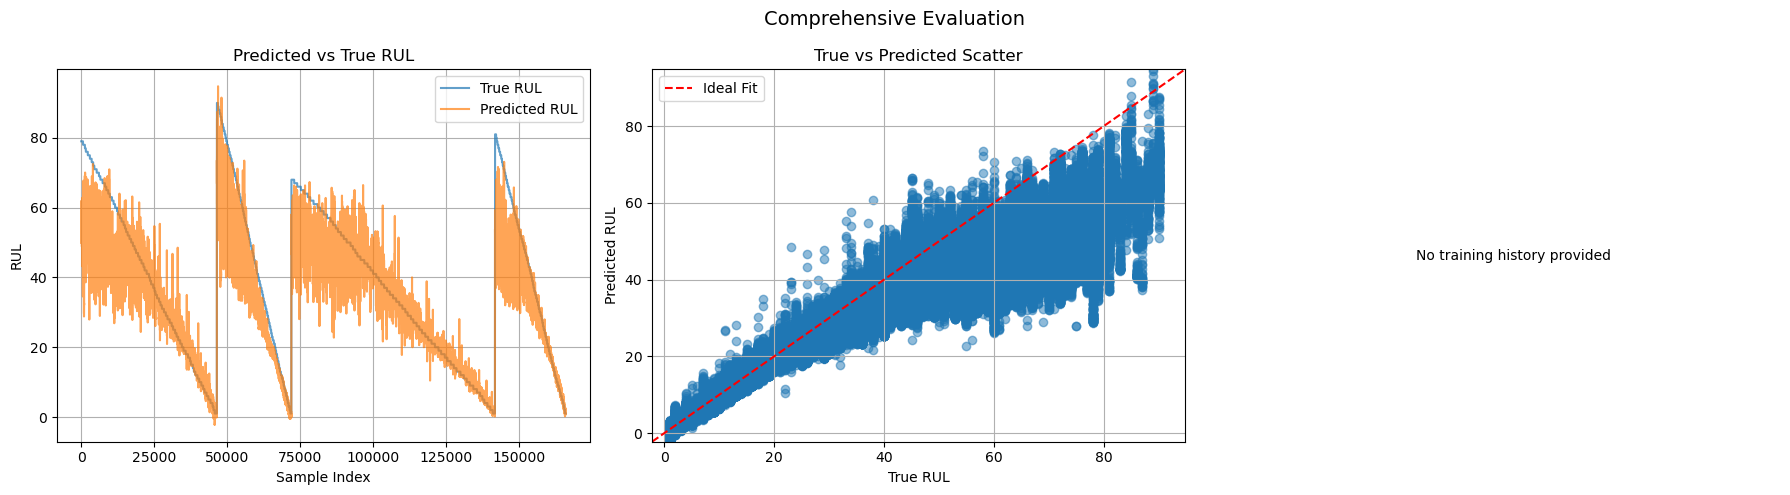

In [37]:

def plot_comprehensive_results(y_true, y_pred, metrics, history=None, title="Comprehensive Evaluation"):
    """Comprehensive performance visualization."""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1️⃣ True vs Predicted
    axs[0].plot(y_true, label="True RUL", alpha=0.7)
    axs[0].plot(y_pred, label="Predicted RUL", alpha=0.7)
    axs[0].set_title("Predicted vs True RUL")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("RUL")
    axs[0].legend()
    axs[0].grid(True)

    # 2️⃣ Scatter
    axs[1].scatter(y_true, y_pred, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    axs[1].plot(lims, lims, "r--", label="Ideal Fit")
    axs[1].set_xlim(lims)
    axs[1].set_ylim(lims)
    axs[1].set_title("True vs Predicted Scatter")
    axs[1].set_xlabel("True RUL")
    axs[1].set_ylabel("Predicted RUL")
    axs[1].legend()
    axs[1].grid(True)

    # 3️⃣ Training History (if available)
    if history is not None:
        axs[2].plot(history.history.get("mae", []), label="Train MAE")
        axs[2].plot(history.history.get("val_mae", []), label="Val MAE")
        axs[2].plot(history.history.get("loss", []), label="Train Loss")
        axs[2].plot(history.history.get("val_loss", []), label="Val Loss")
        axs[2].set_title("Training History")
        axs[2].set_xlabel("Epochs")
        axs[2].set_ylabel("Metric Value")
        axs[2].legend()
        axs[2].grid(True)
    else:
        axs[2].axis("off")
        axs[2].text(0.5, 0.5, "No training history provided", ha="center", va="center")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# Run visualization
plot_comprehensive_results(test_labels, test_predictions, test_metrics)



In [38]:

def show_prediction_samples(y_true, y_pred, n_samples=20):
    """Show random sample predictions."""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    indices = np.random.choice(len(y_true), min(n_samples, len(y_true)), replace=False)
    print("\n" + "="*80)
    print("SAMPLE PREDICTIONS")
    print("="*80)
    print(f"{'Index':<8} {'True RUL':<12} {'Pred RUL':<12} {'Error':<12} {'Abs Error':<12} {'Type':<12}")
    print("-"*80)
    for idx in sorted(indices):
        error = y_pred[idx] - y_true[idx]
        pred_type = "Late (Risk)" if error < 0 else "Early (Safe)"
        print(f"{idx:<8} {y_true[idx]:<12.2f} {y_pred[idx]:<12.2f} {error:<+12.2f} {abs(error):<12.2f} {pred_type:<12}")
    print("="*80 + "\n")

show_prediction_samples(test_labels, test_predictions)



SAMPLE PREDICTIONS
Index    True RUL     Pred RUL     Error        Abs Error    Type        
--------------------------------------------------------------------------------
1851     76.00        60.45        -15.55       15.55        Late (Risk) 
3262     74.00        51.72        -22.28       22.28        Late (Risk) 
23051    41.00        42.67        +1.67        1.67         Early (Safe)
24938    37.00        38.87        +1.87        1.87         Early (Safe)
36044    18.00        18.12        +0.12        0.12         Early (Safe)
41498    9.00         9.85         +0.85        0.85         Early (Safe)
43992    5.00         7.25         +2.25        2.25         Early (Safe)
44055    5.00         5.79         +0.79        0.79         Early (Safe)
45302    2.00         -0.24        -2.24        2.24         Late (Risk) 
55722    58.00        57.89        -0.11        0.11         Late (Risk) 
70705    5.00         3.97         -1.03        1.03         Late (Risk) 
72791    68

In [39]:

def show_best_worst_predictions(y_true, y_pred, n=10):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    errors = y_pred - y_true
    abs_errors = np.abs(errors)
    
    best_idx = np.argsort(abs_errors)[:n]
    worst_idx = np.argsort(abs_errors)[-n:][::-1]
    
    print("\n" + "="*80)
    print(f"TOP {n} BEST PREDICTIONS")
    print("="*80)
    for idx in best_idx:
        print(f"{idx:<8} True={y_true[idx]:<8.2f} Pred={y_pred[idx]:<8.2f} Err={errors[idx]:<+8.2f}")

    print("\n" + "="*80)
    print(f"TOP {n} WORST PREDICTIONS")
    print("="*80)
    for idx in worst_idx:
        pred_type = "Late" if errors[idx] < 0 else "Early"
        print(f"{idx:<8} True={y_true[idx]:<8.2f} Pred={y_pred[idx]:<8.2f} Err={errors[idx]:<+8.2f} ({pred_type})")

show_best_worst_predictions(test_labels, test_predictions)




TOP 10 BEST PREDICTIONS
135729   True=7.00     Pred=7.00     Err=+0.00   
28637    True=30.00    Pred=30.00    Err=+0.00   
122439   True=19.00    Pred=19.00    Err=+0.00   
164997   True=4.00     Pred=4.00     Err=-0.00   
159837   True=20.00    Pred=20.00    Err=+0.00   
55194    True=60.00    Pred=60.00    Err=-0.00   
33056    True=23.00    Pred=23.00    Err=+0.00   
29877    True=28.00    Pred=28.00    Err=-0.00   
108931   True=32.00    Pred=32.00    Err=-0.00   
106402   True=35.00    Pred=35.00    Err=+0.00   

TOP 10 WORST PREDICTIONS
47628    True=87.00    Pred=37.27    Err=-49.73   (Late)
943      True=78.00    Pred=28.80    Err=-49.20   (Late)
944      True=78.00    Pred=28.86    Err=-49.14   (Late)
946      True=78.00    Pred=28.90    Err=-49.10   (Late)
945      True=78.00    Pred=28.90    Err=-49.10   (Late)
947      True=78.00    Pred=28.94    Err=-49.06   (Late)
942      True=78.00    Pred=28.99    Err=-49.01   (Late)
47627    True=87.00    Pred=37.99    Err=-49.01   

In [40]:

def score_metric_fn(y_true, y_pred):
    diff = y_pred - y_true
    return np.mean(np.exp(np.maximum(diff, 0) / 10) - 1 + np.exp(np.maximum(-diff, 0) / 13) - 1)

def analyze_by_rul_ranges(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    ranges = [(0,25,"Critical"),(25,50,"High Risk"),(50,75,"Medium"),(75,100,"Low"),(100,1e9,"Safe")]
    
    print("\n" + "="*80)
    print("PERFORMANCE BY RUL RANGE")
    print("="*80)
    print(f"{'Range':<15}{'Count':<10}{'MAE':<10}{'RMSE':<10}{'NASA':<10}{'Late%':<10}")
    print("-"*80)
    
    for lo, hi, name in ranges:
        mask = (y_true >= lo) & (y_true < hi)
        if np.sum(mask) == 0: continue
        yt, yp = y_true[mask], y_pred[mask]
        mae = mean_absolute_error(yt, yp)
        rmse = root_mean_squared_error(yt, yp)
        score = score_metric_fn(yt, yp)
        late = np.sum((yp - yt) < 0) / len(yt) * 100
        print(f"{name:<15}{len(yt):<10}{mae:<10.2f}{rmse:<10.2f}{score:<10.2f}{late:<10.1f}")
    print("="*80 + "\n")

analyze_by_rul_ranges(test_labels, test_predictions)




PERFORMANCE BY RUL RANGE
Range          Count     MAE       RMSE      NASA      Late%     
--------------------------------------------------------------------------------
Critical       53486     1.43      1.87      0.15      35.5      
High Risk      53293     3.55      4.75      0.39      63.8      
Medium         49398     14.01     15.53     2.39      98.2      
Low            9785      22.47     23.97     5.99      99.9      



In [41]:

def create_summary_report():
    print("\n" + "="*80)
    print("FINAL SUMMARY REPORT".center(80))
    print("="*80)
    
    print("\n📈 PERFORMANCE METRICS")
    print("-"*80)
    print("Validation Set:")
    for k,v in val_metrics.items(): print(f" {k:<15}: {v:.4f}")
    print("\nTest Set:")
    for k,v in test_metrics.items(): print(f" {k:<15}: {v:.4f}")

    test_errors = test_predictions.flatten() - test_labels.flatten()
    late = np.sum(test_errors < 0)
    early = np.sum(test_errors > 0)
    bias = np.mean(test_errors)

    print("\n⚠️ RISK ANALYSIS")
    print("-"*80)
    print(f"Late (Under): {late} ({late/len(test_errors)*100:.1f}%)")
    print(f"Early (Over): {early} ({early/len(test_errors)*100:.1f}%)")
    print(f"Mean Bias: {bias:+.2f}")
    print("="*80 + "\n")

create_summary_report()



                              FINAL SUMMARY REPORT                              

📈 PERFORMANCE METRICS
--------------------------------------------------------------------------------
Validation Set:
 mae            : 4.6619
 mse            : 48.4733
 rmse           : 6.9623
 nasa_score     : 37621.0344
 mape           : 14.9610
 r2             : 0.9066

Test Set:
 mae            : 7.0959
 mse            : 114.0411
 rmse           : 10.6790
 nasa_score     : 205255.9557
 mape           : 16.5592
 r2             : 0.7770

⚠️ RISK ANALYSIS
--------------------------------------------------------------------------------
Late (Under): 111248 (67.0%)
Early (Over): 54714 (33.0%)
Mean Bias: -5.91



In [42]:

# ==========================================
# 📤 Export Predictions
# ==========================================
def export_predictions(y_true, y_pred, filename="predictions.csv"):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    errors = y_pred - y_true
    df = pd.DataFrame({
        "True_RUL": y_true,
        "Predicted_RUL": y_pred,
        "Error": errors,
        "Abs_Error": np.abs(errors),
        "Prediction_Type": ["Late" if e < 0 else "Early" for e in errors]
    })
    return df

predictions_df = export_predictions(test_labels, test_predictions)
predictions_df.head(10)


,True_RUL,Predicted_RUL,Error,Abs_Error,Prediction_Type
0,79.0,61.500282,-17.499718,17.499718,Late
1,79.0,61.787243,-17.212757,17.212757,Late
2,79.0,61.928921,-17.071079,17.071079,Late
3,79.0,61.171028,-17.828972,17.828972,Late
4,79.0,61.493874,-17.506126,17.506126,Late
5,79.0,61.799805,-17.200195,17.200195,Late
6,79.0,61.590164,-17.409836,17.409836,Late
7,79.0,61.447266,-17.552734,17.552734,Late
8,79.0,61.367844,-17.632156,17.632156,Late
9,79.0,61.232430,-17.767570,17.767570,Late
